In [286]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
import transbigdata as tbd
import warnings
warnings.filterwarnings('ignore')

In [338]:
filepath = '小拓扑网络2/'

In [288]:


data = gpd.read_file('高速公路/gis/简化高速/广东省高速公路网_补充后_简化.json')
#提取简化高速公路边信息
edge = data[['geometry']]
edge ['edge_id'] = range (len (edge))
#生成反向边信息
edge_inverse = edge.copy ()
from shapely.geometry import LineString
edge_inverse['geometry'] = edge_inverse['geometry'].apply(lambda x:LineString(list(x.coords)[::-1]))
edge_inverse['edge_id'] +=len (edge)
#合并正反向边信息
edge = pd. concat([edge, edge_inverse])
edge

,geometry,edge_id
0,"LINESTRING (110.14661 20.26271, 110.14665 20.2...",0
1,"LINESTRING (110.13244 20.33307, 110.13250 20.3...",1
2,"LINESTRING (110.13250 20.33423, 110.13328 20.3...",2
3,"LINESTRING (110.13431 20.33518, 110.13328 20.3...",3
4,"LINESTRING (110.13431 20.33518, 110.13541 20.3...",4
...,...,...
24370,"LINESTRING (112.97290 25.29675, 112.97222 25.2...",48745
24371,"LINESTRING (112.97290 25.29675, 112.97197 25.2...",48746
24372,"LINESTRING (112.97222 25.29837, 112.97127 25.2...",48747
24373,"LINESTRING (112.97127 25.29949, 112.97096 25.3...",48748


In [289]:
gdtollnode = pd.read_csv('高速公路/gis/收费站服务区/收费站_all_wgs84.csv')
gdtollnode['name'] = gdtollnode['name'].apply(lambda r:r.split('(')[0])
gdtollnode.drop_duplicates('name',inplace=True)
gdtollnode = gpd.GeoDataFrame(gdtollnode, geometry=gpd.points_from_xy(gdtollnode['lon'], gdtollnode['lat']))
len(gdtollnode)

1044

In [290]:
highway_station = pd.read_csv('高速公路/gis/收费站服务区/服务区_all_wgs84.csv')
highway_station['operId'] = range(len(highway_station))
highway_station = gpd.GeoDataFrame(highway_station, geometry=gpd.points_from_xy(highway_station['lon'], highway_station['lat']))
highway_station = highway_station[['lon','lat','geometry','operId']]
highway_station.columns = ['stationLon','stationLat','geometry','operId']
highway_station['freeNums'] = 10

In [291]:
#highway_station = gpd.read_file('高速公路/充电站.json')
#highway_station = highway_station[['stationLon','stationLat','freeNums','geometry','operId']]
highway_station = gpd.GeoDataFrame(highway_station)
''' highway_station = tbd.ckdnearest_line(highway_station,data)
highway_station = highway_station[highway_station['dist']<1000/111000] '''
highway_station = highway_station[['stationLon','stationLat','operId','freeNums']]
highway_station =  gpd.GeoDataFrame(highway_station)
highway_station['geometry']  = gpd.points_from_xy(highway_station['stationLon'],highway_station['stationLat'])
highway_station.columns = ['lon','lat','场站名称','充电车位数','geometry']
highway_station['充电车位数'] = np.maximum(highway_station['充电车位数'],4)
highway_station[['lon','lat','场站名称','充电车位数']]#.to_csv(r'newdata/chargestation_guangdong.csv',index = None)

,lon,lat,场站名称,充电车位数
0,109.997451,20.741810,0,10
1,109.995547,20.742437,1,10
2,110.284183,21.479282,2,10
3,110.711470,21.470571,3,10
4,110.035249,21.509139,4,10
...,...,...,...,...
401,116.122530,23.823294,401,10
402,116.220267,24.301094,402,10
403,116.555960,23.722856,403,10
404,113.545416,23.127804,404,10


In [292]:
#gdtollnode = pd.read_csv('高速公路/广东省高速公路网_收费站.csv')
gdtollnode['id'] = range(len(gdtollnode))
gdtollnode.to_file(r'高速公路/gis/收费站服务区/收费站_all_wgs84_去重.geojson', driver='GeoJSON')
gdtollnode = gdtollnode[['lon','lat','id']]

#highway_station = pd.read_csv('高速公路/广东省高速公路网_服务区.csv')
highway_station['id'] = range(len(highway_station))
highway_station['id'] += len(gdtollnode)

station = pd.concat ( [gdtollnode, highway_station])
station = gpd. GeoDataFrame (station).reset_index(drop=True)
station ['geometry'] = gpd.points_from_xy(station['lon'],station['lat'])

In [293]:
edge_2 = tbd.ckdnearest_line(station,edge)[[ 'geometry_y', 'edge_id','index']]
edge_1 = edge[edge['edge_id'].apply(lambda r: r not in list(edge_2['edge_id']))]
edge_2.columns = ['geometry', 'edge_id','index']
edge = edge_2.copy()

In [294]:
len(station)

1450

In [295]:


# 基于额外节点调整网络
for i in range(len(station)):
    print(i)
    # 投影、偏移、匹配至最近的边
    dist = 50*1/111000
    # 偏移100米的边
    edge_offset = edge.copy()
    edge_offset = gpd.GeoDataFrame(edge_offset, geometry = 'geometry')
    edge_offset = edge_offset[edge_offset.length>0]
    edge_offset['geometry'] = edge_offset['geometry'].apply(lambda x:x.parallel_offset(dist))
    edge_offset = edge_offset.reset_index(drop=True)
    edge_offset = edge_offset[-edge_offset['geometry'].is_empty]
    station_this = station.iloc[i:i+1]
    
    station_match = tbd.ckdnearest_line(station_this,edge_offset[['edge_id','geometry']])
    nodeid = station_match['id'].iloc[0]
    edgeid = station_match['edge_id'].iloc[0]

    nodegeometry = station[station['id']==nodeid]['geometry'].iloc[0]
    edgegeometry = edge[edge['edge_id']==edgeid]['geometry'].iloc[0]

    #找到edge上距离node最近的点
    projectdist = edgegeometry.project(nodegeometry)
    projectpoint = edgegeometry.interpolate(projectdist)

    #如果在两端，则不需要切分
    #增加端点到节点的线段
    add_edges = []
    if (projectdist==edgegeometry.length)|(projectdist==0):
        line3 = LineString([nodegeometry,projectpoint])
        line4 = LineString([projectpoint,nodegeometry])
        add_edges.append(line3)
        add_edges.append(line4)
    else: #如果在中间，则需要切分，将原始边切分为两段，再加上端点到节点的线段
        from shapely.geometry import Point
        edge_coords = pd.DataFrame(edgegeometry.coords)
        edge_coords['proj'] = edge_coords.apply(lambda r:edgegeometry.project(Point([r[0],r[1]])),axis = 1)
        # 由中间端点切分边为两段
        line1 = LineString(edge_coords[edge_coords['proj']<projectdist][[0,1]].apply(lambda r:Point([r[0],r[1]]),axis = 1).tolist()+[projectpoint])
        line2 = LineString([projectpoint] + edge_coords[edge_coords['proj']>projectdist][[0,1]].apply(lambda r:Point([r[0],r[1]]),axis = 1).tolist())
        # 添加中间端点到收费站的线段
        line3 = LineString([nodegeometry,projectpoint])
        line4 = LineString([projectpoint,nodegeometry])
        add_edges.append(line1)
        add_edges.append(line2)
        add_edges.append(line3)
        add_edges.append(line4)
        # 此时需要删除原有的边
        edge = edge[edge['edge_id']!=edgeid]
        

    # 将新的边加入
    add_edges = gpd.GeoDataFrame(geometry=add_edges)
    
    edge = pd.concat([edge,add_edges])

    # 重新生成边的id
    edge['edge_id'] = range(len(edge))

edge = pd.concat([edge,edge_1])

# 构建节点表
edge['slon'] = edge['geometry'].apply(lambda r:r.coords[0][0])
edge['slat'] = edge['geometry'].apply(lambda r:r.coords[0][1])
edge['elon'] = edge['geometry'].apply(lambda r:r.coords[-1][0])
edge['elat'] = edge['geometry'].apply(lambda r:r.coords[-1][1])


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [296]:

# 提取简化高速公路节点信息
node = pd.concat([edge[['slon','slat']].rename(columns = {'slon':'lon','slat':'lat'}),
                  edge[['elon','elat']].rename(columns = {'elon':'lon','elat':'lat'})]).drop_duplicates()
node['geometry'] = gpd.points_from_xy(node['lon'],node['lat'])
node['id'] = range(len(node)) 

# 生成收费站节点对应网络节点的编号
station2node = tbd.ckdnearest_point(station,node)[['id_x','id_y']].rename(columns = {'id_x':'station_id','id_y':'node_id'})

# 为边添加起终点接节点信息
## 添加起点信息
node_tmp = node[['lon','lat','id']]
node_tmp.columns = ['slon','slat','u']
edge = pd.merge(edge,node_tmp,on = ['slon','slat'],how = 'left')
## 添加终点信息
node_tmp = node[['lon','lat','id']]
node_tmp.columns = ['elon','elat','v']
edge = pd.merge(edge,node_tmp,on = ['elon','elat'],how = 'left')

edge = gpd.GeoDataFrame(edge,geometry = 'geometry')

edge.crs = 'EPSG:4326'
edge['length'] = edge.to_crs('EPSG:4525').length
edge = edge[edge['length']>0]

ValueError: Assigning CRS to a GeoDataFrame without a geometry column is not supported. Use GeoDataFrame.set_geometry to set the active geometry column.

In [343]:

# 高速公路边向右平移一定距离形成面
def generate_plane(edge,dist = 100):
    '''
    高速公路边向右平移一定距离形成面

    '''
    ## 转换为投影坐标系
    edge.crs = 'EPSG:4326'
    edge['length'] = edge.to_crs('EPSG:4525').length

    edge = edge[edge['length']>50]
    edge_plane = edge.to_crs('EPSG:4525') #CGCS2000 / 3-degree Gauss Kruger zone 37
    edge['length'] = edge_plane['geometry'].length

    ## 生成单方向偏移
    from shapely.geometry import Polygon
    edge_plane['geometry'] = edge_plane['geometry'].apply(lambda x:Polygon(list(x.coords)+list(x.parallel_offset(dist).coords)))
    edge_plane = edge_plane.to_crs('EPSG:4326')
    return edge_plane

edge_plane = generate_plane(edge,dist = 100)

In [344]:

#存储边、面与节点信息
edge.to_file(filepath+r'广东省高速公路_简化_边.json',driver = 'GeoJSON')
edge_plane.to_file(filepath+r'广东省高速公路_简化_面.json',driver = 'GeoJSON')
node = gpd.GeoDataFrame(node)
node.to_file(filepath+r'广东省高速公路_简化_节点.json',driver = 'GeoJSON')
station2node.to_csv(filepath+r'收费站节点对应网络节点的编号.csv',index = None)

<AxesSubplot:>

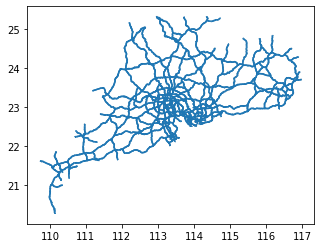

In [336]:
edge.plot()

In [333]:
len(station2node)

1450

In [345]:
#存储边、面与节点信息
edge = gpd.read_file(filepath+r'广东省高速公路_简化_边.json')
#edge_plane = gpd.read_file(r'小拓扑网络/广东省高速公路_简化_面.json')
node = gpd.read_file(filepath+r'广东省高速公路_简化_节点.json')
station2node = pd.read_csv(filepath+r'收费站节点对应网络节点的编号.csv')
# 将station2node转换为字典
station2node_dict = station2node.set_index('station_id')['node_id'].to_dict()


In [346]:
G_edges = edge[['u','v','length']].values
G_nodes = list(node['id'])

import networkx as nx
#先创建一个有向图
G = nx.DiGraph()
#添加节点
G.add_nodes_from(G_nodes) 
#添加边
G.add_weighted_edges_from(G_edges)

## OD表构建
o = gdtollnode[['id']].copy()
o.columns = ['station_id']
#o = station2node[['station_id']]
o['flag'] = 1
d = o.copy()
od = pd.merge(o,d,on = 'flag')[['station_id_x','station_id_y']]
od = od[od['station_id_x']!=od['station_id_y']]

# 获取出行路径
def getshortestpath(r):
    # 获取出行路径
    start_node = station2node_dict[r['station_id_x']]
    end_node = station2node_dict[r['station_id_y']]
    shortest_path = nx.shortest_path(G, source=start_node, target=end_node)
    return list(map(int,shortest_path))# 转为整型

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

# 获取OD的出行路径
od['path'] = od.parallel_apply(lambda r:getshortestpath(r),axis = 1)
# 对OD编号
od['odid'] = range(len(od))
od.to_csv(filepath+r'OD路径表.csv',index = None)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [87]:

def get_path_gdf_1(shortest_path):
    '''
    从点序列中获取出行路段
    '''
    path = pd.DataFrame(shortest_path,columns=['u'])
    path['u'] = path['u'].astype(int)
    path['v'] = path['u'].shift(-1).fillna(0).astype(int)
    path = path.iloc[:-1]
    path = gpd.GeoDataFrame(path)
    path['id'] = range(len(path))
    return path
#path = get_path_gdf(shortest_path,edge)
import ast
def get_path_dis_table_1(r):
    '''
    获取OD所经过的路段信息
    '''
    shortest_path = ast.literal_eval(r['path'])
    path = get_path_gdf_1(shortest_path)
    path = path[['u','v','id']]
    path['station_id_x'] = r['station_id_x']
    path['station_id_y'] = r['station_id_y']
    return path
od1_tmp = od.groupby('odid').parallel_apply(lambda r:get_path_dis_table_1(r.iloc[0])).reset_index()[['station_id_x','station_id_y','u','v','id']]
od1_tmp = pd.merge(od1_tmp,edge)[['station_id_x','station_id_y','edge_id','length','id']]

od1_tmp = od1_tmp.sort_values(by = ['station_id_x','station_id_y','id'])
od1_tmp['cumsumlength'] = od1_tmp.groupby(['station_id_x','station_id_y'])['length'].cumsum()
od_dis_table = od1_tmp[['station_id_x','station_id_y','edge_id','cumsumlength']]

# od_dis_table存储了每个OD对应的路段信息
# 其中，station_id_x、station_id_y为OD的起点、终点
# edge_id为经过路段的id，cumsumlength为经过路段的累计长度
# 例如，station_id_x=0，station_id_y=1，edge_id=47784，cumsumlength=68.596574，表示OD为0-1的出行路径，需要经过id为47784的路段，路径走完这一路段时，所经过的长度为68.596574米
od_dis_table.to_csv(filepath+r'od_dis_table.csv',index = None)


od_length = od_dis_table.groupby(['station_id_x','station_id_y'])['cumsumlength'].max().rename('length').reset_index()
od_length.to_csv(filepath+r'od_length.csv',index = None)

In [ ]:
od = pd.read_csv(filepath+r'OD路径表.csv')
def get_path_gdf(shortest_path,edge):
    '''
    从点序列中获取出行路段
    '''
    path = pd.DataFrame(shortest_path,columns=['u'])
    path['u'] = path['u'].astype(int)
    path['v'] = path['u'].shift(-1).fillna(0).astype(int)
    path = path.iloc[:-1]
    path = gpd.GeoDataFrame(path)
    path = pd.merge(path,edge)
    path['cumsumlength'] = path['length'].cumsum()
    return path
#path = get_path_gdf(shortest_path,edge)
import ast
def get_path_dis_table(r,edge):
    '''
    获取OD所经过的路段信息
    '''
    shortest_path = ast.literal_eval(r['path'])
    path = get_path_gdf(shortest_path,edge)
    path = path[['edge_id','cumsumlength']]
    path['station_id_x'] = r['station_id_x']
    path['station_id_y'] = r['station_id_y']
    return path

#获取OD所经过的路段信息

od_dis_table = od.groupby('odid').parallel_apply(lambda r:get_path_dis_table(r.iloc[0],edge)).reset_index()[['station_id_x','station_id_y','edge_id','cumsumlength']]

# od_dis_table存储了每个OD对应的路段信息
# 其中，station_id_x、station_id_y为OD的起点、终点
# edge_id为经过路段的id，cumsumlength为经过路段的累计长度
# 例如，station_id_x=0，station_id_y=1，edge_id=47784，cumsumlength=68.596574，表示OD为0-1的出行路径，需要经过id为47784的路段，路径走完这一路段时，所经过的长度为68.596574米
od_dis_table.to_csv(filepath+r'od_dis_table.csv',index = None)


od_length = od_dis_table.groupby(['station_id_x','station_id_y'])['cumsumlength'].max().rename('length').reset_index()
od_length.to_csv(filepath+r'od_length.csv',index = None)

KeyboardInterrupt: 

In [ ]:
highway_station = pd.merge(highway_station,station2node,left_on = 'id',right_on = 'station_id')

In [ ]:
# find the nearest charge node
def get_nearest_charge_station(G,node_id, radius = 1000):
    # create subgraph
    subgraph = nx.ego_graph (G, node_id, radius=radius,distance = 'weight')
    distances = []
    stationid = None
    stationdistance = None
    for node in subgraph.nodes() :
        if (node in list(highway_station ['node_id'])):# if it is charge station
            distance = nx.shortest_path_length(subgraph,source=node_id, target=node,weight='weight')
            distances.append ( [node, distance])
    distances = pd.DataFrame (distances, columns=['stationid', 'distance']) .sort_values (by='distance')
    # if there is a charge staion
    if len (distances)>0:
        stationid = int (distances ['stationid'].iloc [0])
        stationdistance = int (distances ['distance'].iloc[0])
    return stationid, stationdistance
stationid,stationdistance = get_nearest_charge_station(G,0, radius = 1000)
stationid,stationdistance

(20739, 57281)

In [ ]:
# find the nearest charge node
G_nodes_df = pd. DataFrame (G_nodes,columns = ['node_id'])
a = G_nodes_df['node_id'].parallel_apply(lambda node_id:get_nearest_charge_station(G,node_id,radius = 1000))
G_nodes_df['charge_node_id'] = a.apply(lambda r:r [0])
G_nodes_df['charge_node_distance'] = a.apply (lambda r:r [1])

In [ ]:
edge_to_charge = pd.merge(edge[['edge_id', 'v']].rename(columns={'v': 'node_id'}),
                          G_nodes_df)[['edge_id', 'charge_node_id', 'charge_node_distance']]
edge_to_charge = pd.merge(edge_to_charge,
                          highway_station[['场站名称', '充电车位数', "node_id"]].rename(
                              columns={'node_id': 'charge_node_id'})).sort_values(by='edge_id')
edge_to_charge.to_csv(filepath+r'edge_to_charge.csv',index = None)


# OD路径抽样概率

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import transbigdata as tbd
import warnings
warnings.filterwarnings('ignore')

In [11]:
#生成假的OD分布概率
od = pd.read_csv(filepath+r'OD路径表.csv')
node = gpd.read_file(filepath+r'广东省高速公路_简化_节点.json')
station2node = pd.read_csv(filepath+r'收费站节点对应网络节点的编号.csv')
station_node = pd.merge(node,station2node,left_on='id',right_on='node_id')
station_node = station_node[['lon','lat','geometry','station_id']]
station_node = station_node[station_node['station_id']<len(gdtollnode)]


highway_station = pd.read_csv('高速公路/gis/收费站服务区/服务区_all_wgs84.csv')
highway_station['operId'] = range(len(highway_station))
highway_station = gpd.GeoDataFrame(highway_station, geometry=gpd.points_from_xy(highway_station['lon'], highway_station['lat']))

stationcount = tbd.ckdnearest_point(highway_station,station_node).groupby('station_id')['dist'].mean().rename('count').reset_index()
station_node = pd.merge(station_node,stationcount)
station_node['count']/=station_node['count'].max()
station_node['count'] = 1/station_node['count']
station_node.loc[station_node['count']>1000,'count']=1000
station_node['prob']  = station_node['count']/station_node['count'].sum()
station_node[['station_id','prob']].to_csv(filepath+r'O_prob.csv',index = None)